# K2-233: LC and multi-GP RV fit

We will analyse the LC and RV data of the 3-planet system, K2-233 as published in [Barragan et al. 2023](https://doi.org/10.1093/mnras/stad1139)

In [1]:
import CONAN
import matplotlib.pyplot as plt
import numpy as np
CONAN.__version__

'3.3.12'

In [ ]:
%matplotlib inline

## Data Analysis

### Setup LC

load_lightcurves(): loading lightcurves from path -  data/
Supersampling K2-233_C15_detrended_cut.dat with exp_time=29.4mins each divided into 30 subexposures
# ============ Input lightcurves, filters baseline function =======================================================
name                         flt 𝜆_𝜇m |Ssmp ClipOutliers scl_col |off col0 col3 col4 col5 col6 col7 col8|sin id GP spline         
K2-233_C15_detrended_cut.dat V   0.6  |x30  None         None    |  y    0    0    0    0    0    0    0|n    1 n  None           


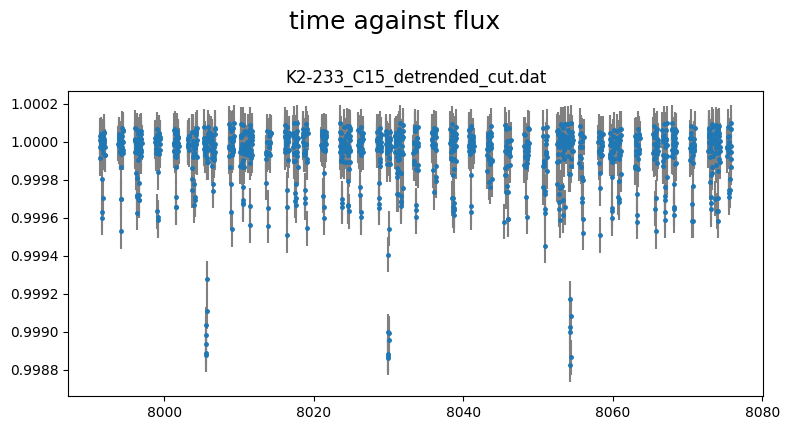

In [ ]:
lc_obj = CONAN.load_lightcurves("K2-233_C15_detrended_cut.dat", data_filepath="data", nplanet=3)
lc_obj.supersample("K2-233_C15_detrended_cut.dat", ss_factor=30)
lc_obj.plot()

In [ ]:
traocc_pars =dict(  T_0           = [(7991.6745, 7991.6897, 7991.7077),    #planet 1
                                     (7586.8425, 7586.862,  7586.9105),    #planet 2
                                     (8005.5640, 8005.5802, 8005.6008)],   #planet 3

                    Period        = [(2.4667, 2.467, 2.4683),
                                     (7.0547, 7.060, 7.0655), 
                                     (24.3509,24.36, 24.3781)],

                    Impact_para   = [(0,0.13,0.5),
                                      (0,0.13,0.5),
                                      (0,0.3,0.5)],

                    RpRs          = (0.01, 0.02, 0.05),

                    rho_star      = (3.17,0.07),  #g/cm^3 - unit of stellar density   
                    
                    K             = (0,2,5),        #m/s - unit of rv data

                    Eccentricity  = [0,
                                     0,
                                     (0,0.1,0.3) ],        #unitless

                    omega         = [90,
                                     90,
                                     (0,90, 360)]

                
                  )


In [ ]:
lc_obj.planet_parameters(**traocc_pars)

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                       fit 	prior                              	note
[rho_star]/Duration        y   	N(3.17,0.07)                       	#choice in []|unit(gcm^-3/days)
--------repeat this line & params below for multisystem, adding '_planet_number' to the names e.g RpRs_1 for planet 1, ...
RpRs_1                     y   	U(0.01,0.02,0.05)                  	#range[-0.5,0.5]
Impact_para_1              y   	U(0,0.13,0.5)                      	#range[0,2]
T_0_1                      y   	U(7991.6745,7991.6897,7991.7077)   	#unit(days)
Period_1                   y   	U(2.4667,2.467,2.4683)             	#range[0,inf]days
[Eccentricity_1]/sesinw_1  n   	F(0)                               	#choice in []|range[0,1]/range[-1,1]
[omega_1]/secosw_1         n   	F(90)                              	#choice in []|range[0,360]deg/range[-1,1]
K_1                        y   	U(0,2,5)  

In [ ]:
lc_obj.limb_darkening(q1=(0,0.2,1), q2=(0,0.2,1))

# ============ Limb darkening setup ============================================================================= 
filters	fit	q1               	q2               
V      	y  	U(0,0.2,1)       	U(0,0.2,1)       


### Setup RV

In [ ]:
rv_obj = CONAN.load_rvs( file_list = "k2_233rv.dat",
                        data_filepath="data",
                         nplanet       = 3,
                         rv_unit       = "m/s",
                         lc_obj        = lc_obj
                        )


load_rvs(): loading RVs from path - data/


Let's see what the data looks like, using pandas to read the ndarray

In [ ]:
import pandas as pd

pd.DataFrame(rv_obj._input_rv["k2_233rv.dat"]).head()

,col0,col1,col2,col3,col4,col5
0,8257.575545,-9622.0,1.9,7650.8,17.4,0.6893
1,8257.636216,-9624.4,2.0,7654.2,15.6,0.6941
2,8257.755000,-9626.0,2.0,7663.5,21.3,0.7034
3,8258.564438,-9659.2,1.9,7683.5,56.6,0.7124
4,8258.658789,-9666.3,2.2,7659.1,43.6,0.6915


- `col0`: time
- `col1`: RV (m/s)
- `col2`: RV error (m/s)
- `col3`: FWHM (m/s)
- `col4`: BIS (m/s)
- `col5`: S'HK

let's see what `col1`,`col3`,`col4` look loike as a function of time

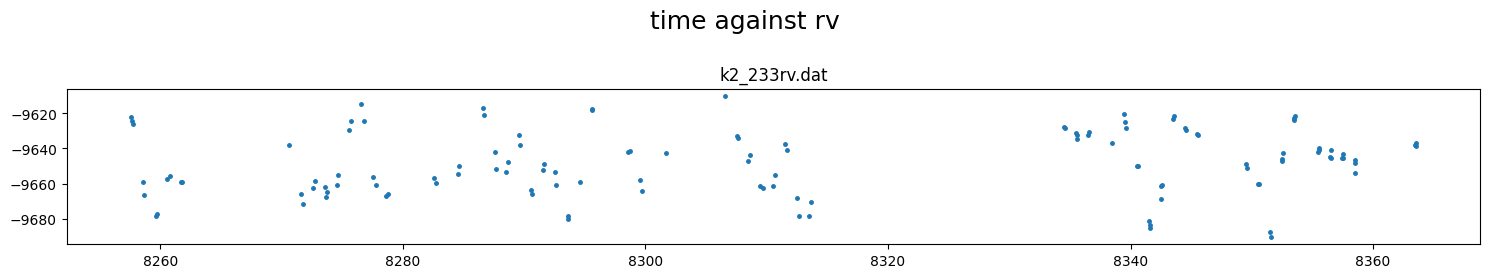

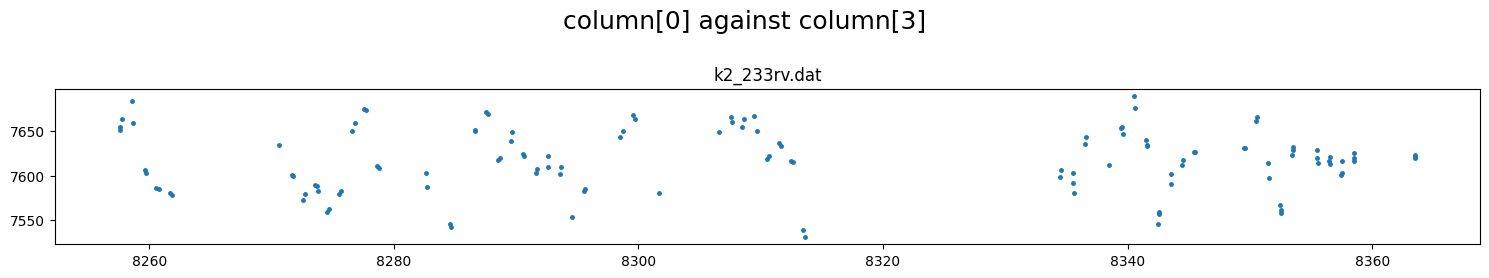

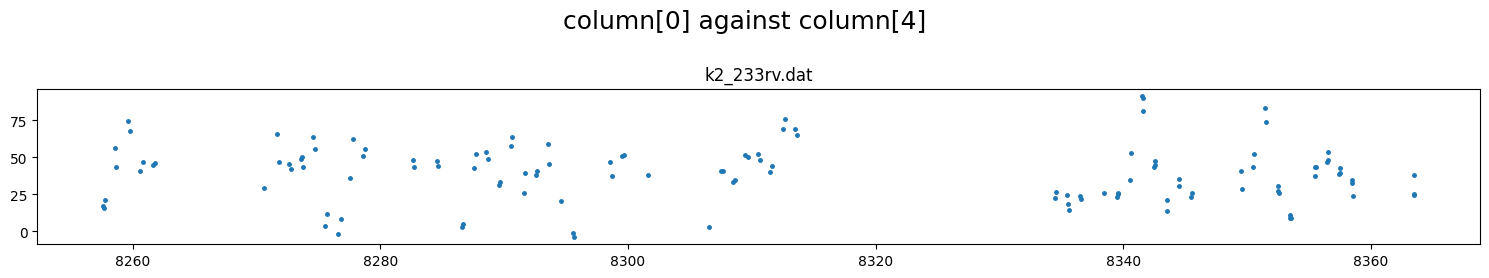

In [ ]:
rv_obj.plot(plot_cols=(0,1), figsize=(15,3))
rv_obj.plot(plot_cols=(0,3), figsize=(15,3))
rv_obj.plot(plot_cols=(0,4), figsize=(15,3))

We will run a multidimensional GP (with Spleaf) using a quasiperiodic kernel that models the stellar activity signal across the 3 time series following the method used in [Barragan et al. 2023](https://doi.org/10.1093/mnras/stad1139).

Each timeseries in modeled by a linear combination of the qp kernel and its derivative  with amplitudes h1(amplitude) and h5

In [ ]:
rv_obj.rv_baseline(gamma = (-9700, -9650, -9600))

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name         RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_m/s      
k2_233rv.dat m/s    None    |   0    0    0    0|   0 n  None            | U(-9700,-9650,-9600)


#### add RV GP

In [ ]:
rv_obj.add_rvGP(rv_list         = 'k2_233rv.dat',
                                #     #RV            #FWHM           #BIS
                    par         = [( "col1",         "col3",         "col4"          )],
                    err_col     = [( "col2",         "col2",         "col2"          )],
                    kernel      = [( "qp",           "qp",           "qp"            )],
                    amplitude   = [( (0., 4, 100),   (0., 1, 100),   (-100,0,100)    )],  
                    lengthscale = [( (1,10, 500),    None,           None            )],
                    h3          = [( (0.1,0.5,5),    None,           None            )],
                    h4          = [( (8,10,12),      None,           None            )],
                    h5          = [( (-100, 0, 100),  0,            (-100, 0, 100)   )],
                    operation   = [(                 "+",            "+"             )],
                    gp_pck      = "sp",
                    )

# ============ Input RV curves, baseline function, GP, spline,  gamma ============================================ 
name         RVunit scl_col |col0 col3 col4 col5| sin GP spline_config   | gamma_m/s      
k2_233rv.dat m/s    None    |   0    0    0    0|   0 sp None            | F(0.0)        
# ============ RV GP properties (start newline with name of * or + to Xply or add a 2nd gp to last file) =======
name         kern  par    h1:[Amp_ppm]       h2:[len_scale]     h3:[Q,η,C,α,b]     h4:[P]       | h5:[Der_Amp_ppm] ErrCol
k2_233rv.dat qp    col1   U(0.0,4,100)       U(1,10,500)        U(0.1,0.5,5)       U(8,10,12)   | U(-100,0,100)    col2  
         |+| qp    col3   U(0.0,1,100)       None               None               None         | F(0)             col2  
         |+| qp    col4   U(-100,0,100)      None               None               None         | U(-100,0,100)    col2  


### Setup Sampling

In [ ]:
fit_obj = CONAN.fit_setup(  R_st = (0.71,0.01),
                            M_st = (0.79,0.01))

fit_obj.sampling(n_cpus=10,n_live=100)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(0.71,0.01)
Mass_[Msun]    N(0.79,0.01)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    100 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n,list)                  y 
apply_RVjitter(y/n,list)                  y 
LCjitter_loglims(auto/[lo,hi])      

### Save / Load config file

In [ ]:
CONAN.create_configfile(None, rv_obj, fit_obj,
                            filename='k2-233_lcrv_spleaf_multiGP.dat')

configuration file saved as k2-233_lcrv_spleaf_multiGP.dat


if config file already saved to file. It can be reloaded to create all required objects to perform the fit

In [ ]:
import CONAN
lc_obj, rv_obj, fit_obj = CONAN.load_configfile('k2-233_lcrv_spleaf_multiGP.dat')

load_lightcurves(): loading lightcurves from path -  data/
load_rvs(): loading RVs from path - data/


### Perform the fit

In [ ]:
result = CONAN.run_fit(lc_obj, rv_obj, fit_obj, 
                        out_folder="result_k2-233_LC_RV3D_GP",
                        rerun_result=True
                        # resume_sampling=True,
                        );

Creating output folder...result_k2-233_LC_RV3D_GP
configuration file saved as result_k2-233_LC_RV3D_GP/config_save.dat

================ CONAN fit launched!!! ================

Setting up photometry arrays ...
Setting up RV arrays ...

Plotting prior distributions ...
----------------------------------

Generating initial model(s) ...
--------------------------- [0.26 secs]

Plotting initial model(s) ...
--------------------------- [4.08 secs]

Fit setup
----------
No of cpus: 10
No of dimensions: 36
fitting parameters:  ['rho_star' 'T_0_1' 'RpRs_1' 'Impact_para_1' 'Period_1' 'K_1' 'T_0_2'
 'RpRs_2' 'Impact_para_2' 'Period_2' 'K_2' 'T_0_3' 'RpRs_3'
 'Impact_para_3' 'Period_3' 'sesin(w)_3' 'secos(w)_3' 'K_3' 'V_q1' 'V_q2'
 'lc1_logjitter' 'rv1_gamma' 'rv1_jitter' 'lc1_off' 'GPrv1_Amp1_col1'
 'GPrv1_len1_col1' 'GPrv1_η1_col1' 'GPrv1_P1_col1' 'GPrv1_DerAmp1_col1'
 'GPrv1_Amp2_col3' 'GPrv1_Amp3_col4' 'GPrv1_DerAmp3_col4' 'rv1_off_col3'
 'rv1_off_col4' 'rv1_jitt_col3' 'rv1_jitt_col4']

====

30237it [5:54:34,  1.42it/s, +360 | bound: 496 | nc: 1 | ncall: 1650088 | eff(%):  1.855 | loglstar:   -inf < 9354.515 <    inf | logz: 9272.894 +/-  0.446 | dlogz:  0.000 >  0.100]



Dynesty chain written to disk as result_k2-233_LC_RV3D_GP/chains_dict.pkl. Run `result=CONAN.load_result()` to load it.

============ Sampling Finished ==============================================[5.92hrs]

Making corner plot(s) ...
----> saved 3 corner plot(s) as result_k2-233_LC_RV3D_GP/corner_*.png [19.70 secs]


Creating *out.dat files using the median posterior ...
    - Writing LC output to file: result_k2-233_LC_RV3D_GP/out_data/K2-233_C15_detrended_cut_lcout.dat
    - Writing RV output with GP(Spleaf) to file: result_k2-233_LC_RV3D_GP/out_data/k2_233rv_rvout.dat

 ----> Plotting figures using median posterior values ...[4.32 secs]

 ----> Plotting figures using max posterior values ...[5.64 secs]

Computing AIC, BIC stats ...[0.00 secs]

Computing photometric noise (red and white) correction factors ... [24.019403219223022 secs


['lc'] Output files, ['K2-233_C15_detrended_cut_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load l

## Load result

In [1]:
import CONAN
from CONAN.utils import bin_data, phase_fold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
result =CONAN.load_result("result_k2-233_LC_RV3D_GP")
result

['lc'] Output files, ['K2-233_C15_detrended_cut_lcout.dat'], loaded into result object
load_lightcurves(): input_lc is provided, using it to load lightcurves.
['rv'] Output files, ['k2_233rv_rvout.dat'], loaded into result object
load_rvs(): input_rv is provided, using it to load rvs.
Linking the last created lightcurve object to the rv object for parameter linking. if this is not the related LC object, input the correct one using `lc_obj` argument of `load_rvs()`
.


Object containing posterior from emcee/dynesty sampling                 
Parameters in chain are:
	 ['rho_star', 'T_0_1', 'RpRs_1', 'Impact_para_1', 'Period_1', 'K_1', 'T_0_2', 'RpRs_2', 'Impact_para_2', 'Period_2', 'K_2', 'T_0_3', 'RpRs_3', 'Impact_para_3', 'Period_3', 'sesin(w)_3', 'secos(w)_3', 'K_3', 'V_q1', 'V_q2', 'lc1_logjitter', 'rv1_gamma', 'rv1_jitter', 'lc1_off', 'GPrv1_Amp1_col1', 'GPrv1_len1_col1', 'GPrv1_η1_col1', 'GPrv1_P1_col1', 'GPrv1_DerAmp1_col1', 'GPrv1_Amp2_col3', 'GPrv1_Amp3_col4', 'GPrv1_DerAmp3_col4', 'rv1_off_col3', 'rv1_off_col4', 'rv1_jitt_col3', 'rv1_jitt_col4']                 

use `plot_chains()`, `plot_burnin_chains()`, `plot_corner()` or `plot_posterior()` methods on selected parameters to visualize results.

### RVS

In [3]:
result.rv.names

['k2_233rv.dat']

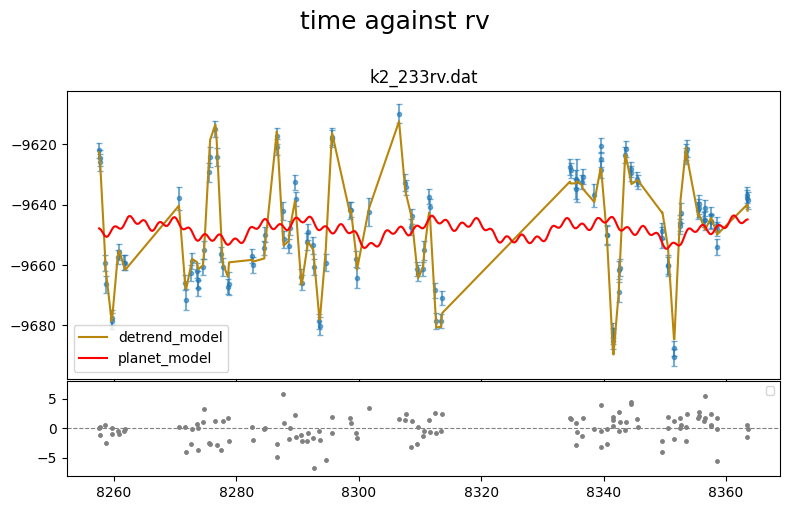

In [4]:
fig = result.rv.plot_bestfit()

Let's see how well the multi_GP modeled the timeseries. The GP object is stored in `result.rv.GP`

In [5]:
result.rv.GP['k2_233rv.dat'].get_param_dict()

{'GPrv1_Amp1_col1': 5.559818737765244,
 'GPrv1_len1_col1': 18.773467070856324,
 'GPrv1_η1_col1': 0.4525160513396689,
 'GPrv1_P1_col1': 9.796793253671636,
 'GPrv1_DerAmp1_col1': 26.417553906775268,
 'GPrv1_Amp2_col3': 42.74814429900554,
 'GPrv1_len2_col3': nan,
 'GPrv1_η2_col3': nan,
 'GPrv1_P2_col3': nan,
 'GPrv1_DerAmp2_col3': 0.0,
 'GPrv1_Amp3_col4': -1.3008287399119354,
 'GPrv1_len3_col4': nan,
 'GPrv1_η3_col4': nan,
 'GPrv1_P3_col4': nan,
 'GPrv1_DerAmp3_col4': -27.20793985442789}

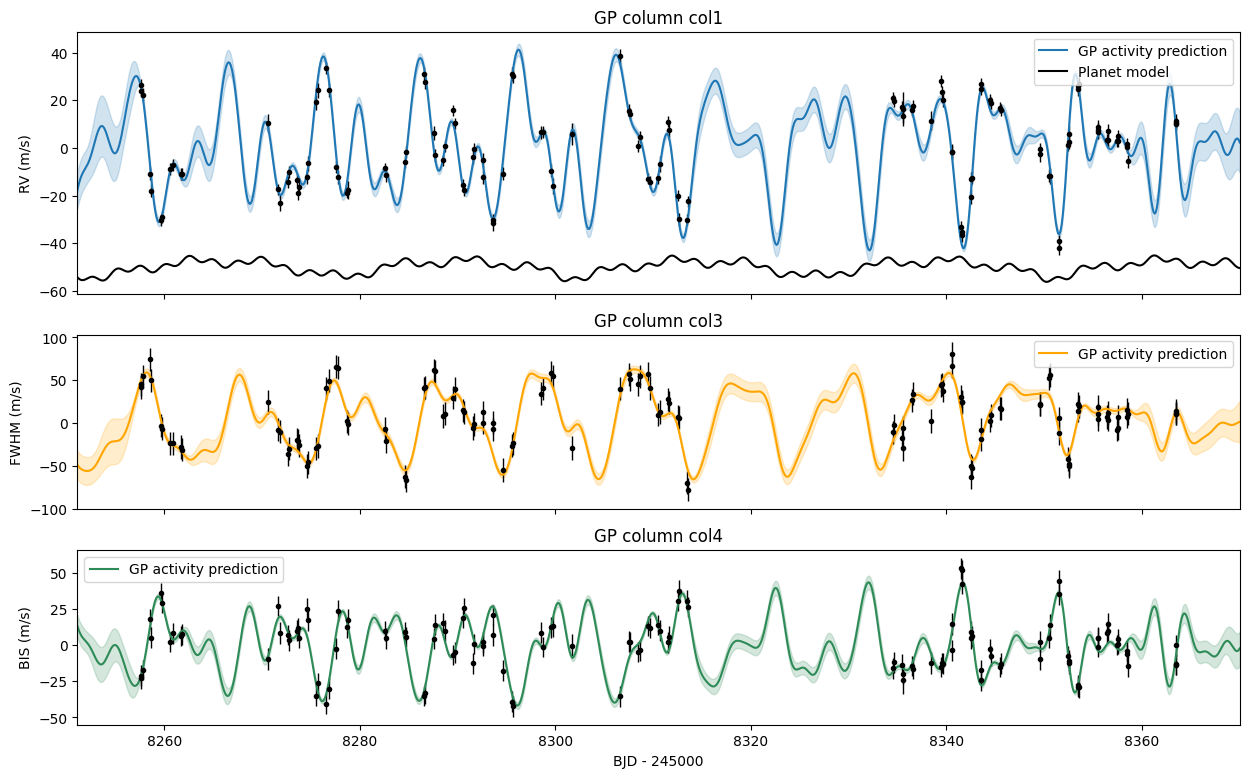

In [6]:

ndim_gp     = result.rv.GP['k2_233rv.dat'].ndim_gp
gp_cols     = result.rv.GP['k2_233rv.dat'].gp_cols
gp_cols_err = result.rv.GP['k2_233rv.dat'].gp_cols_err
colors      = ["C0","orange","seagreen"]
ylabel      = ["RV (m/s)","FWHM (m/s)","BIS (m/s)"]

pred_x      = np.linspace(  result.rv.indata['k2_233rv.dat']["col0"].min()-6.5, 
                            result.rv.indata['k2_233rv.dat']["col0"].max()+6.5, 
                            1000)
planet_mod  = result.rv.evaluate(time=pred_x).planet_model


fig, ax = plt.subplots(ndim_gp, 1, figsize=(15,9), sharex=True, height_ratios=[3,2,2])
for i,(col,col_err) in enumerate(zip(gp_cols,gp_cols_err)):

    pred_col, var_col = result.rv.GP['k2_233rv.dat'].predict(x=pred_x, series_id=i, return_var=True)

    off  = result.params_dict[f'rv1_off_{col}'].n  if i>0 else result.params_dict['rv1_gamma'].n
    jitt = result.params_dict[f'rv1_jitt_{col}'].n if i>0 else result.params_dict[f'rv1_jitter'].n 

    #PLOTTING
    ax[i].set_ylabel(ylabel[i])
    ax[i].set_title(f"GP column {col}")
    ax[i].errorbar( result.rv.indata['k2_233rv.dat']["col0"], 
                    result.rv.indata['k2_233rv.dat'][col]-off, 
                    yerr=np.hypot(result.rv.indata['k2_233rv.dat'][col_err], jitt), 
                    fmt=".", c="k", elinewidth=1)
    ax[i].fill_between( pred_x,
                        pred_col - np.sqrt(var_col),
                        pred_col + np.sqrt(var_col),
                        color=colors[i], alpha=0.2)
    ax[i].plot(pred_x, pred_col, "-", c=colors[i], label="GP activity prediction")
    if i==0:
        ax[i].plot(pred_x, planet_mod-50, "-", c="k", label="Planet model")

    ax[i].legend()

plt.xlim([min(pred_x), max(pred_x)])
plt.xlabel("BJD - 245000")
plt.show()

In [7]:
#load output data files for the rv fits
rv_out = result.rv.outdata['k2_233rv.dat']
rv_out.head()

,time,RV,error,full_mod,base_para,base_spl,base_gp,base_total,Rvmodel,det_RV,gamma,residual,phase_1,phase_2,phase_3
0,8257.575545,-9622.0,2.607588,-9622.003806,0.0,0.0,25.836100,-9622.552057,0.548251,0.552057,-9648.388157,0.003806,-0.246882,0.000247,0.341441
1,8257.636216,-9624.4,2.681327,-9623.281532,0.0,0.0,24.600069,-9623.788088,0.506556,-0.611912,-9648.388157,-1.118468,-0.222295,0.008841,0.343931
2,8257.755000,-9626.0,2.681327,-9626.319460,0.0,0.0,21.729330,-9626.658827,0.339367,0.658827,-9648.388157,0.319460,-0.174156,0.025666,0.348806
3,8258.564438,-9659.2,2.607588,-9659.761829,0.0,0.0,-9.331622,-9657.719779,-2.042050,-1.480221,-9648.388157,0.561829,0.153879,0.140318,0.382024
4,8258.658789,-9666.3,2.833640,-9663.837893,0.0,0.0,-13.264544,-9661.652702,-2.185192,-4.647298,-9648.388157,-2.462107,0.192116,0.153682,0.385896


In [8]:
# evaluate the RV model
rvmod = result.rv.evaluate( time        = np.array(rv_out["time"]), 
                            return_std  = True, 
                            nsamp       = 500)

since the RVs are sparsely sampled, we can evaluate the RV model on a smoother time array across both datasets

In [71]:
t_sm     = np.linspace( rv_out["time"].min()-6.5, 
                        rv_out["time"].max()+6.5, 
                        10000)

rvmod_sm = result.rv.evaluate(  file       = 'k2_233rv.dat',
                                time       = t_sm,  
                                return_std = True,
                                nsamp      = 500)

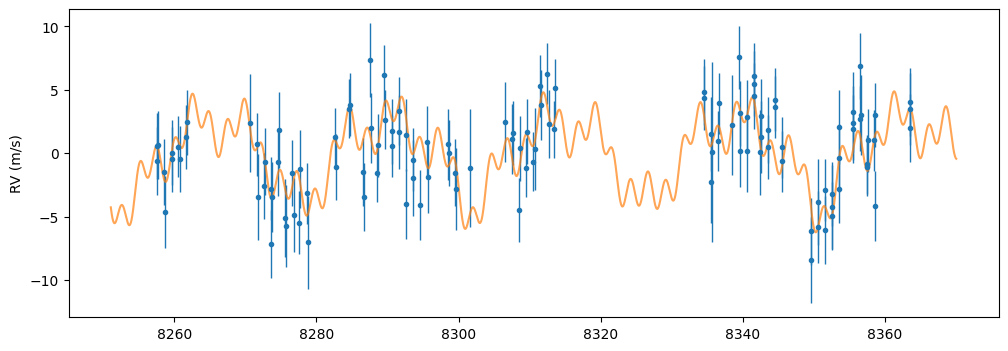

In [72]:
plt.figure(figsize=(12,4))
plt.errorbar(rv_out["time"],rv_out["det_RV"], rv_out["error"],fmt=".", elinewidth=1)
plt.plot(t_sm, rvmod_sm.planet_model, alpha=0.7)
plt.ylabel("RV (m/s)");

#### Individual components

In [73]:
result.params.P, result.params.T0

([2.467538865661981, 7.059961178010269, 24.367385376491498],
 [7991.690538872866, 7586.877488697929, 8005.581655984773])

In [74]:
rv_comp    = rvmod.components
rv_comp_sm = rvmod_sm.components

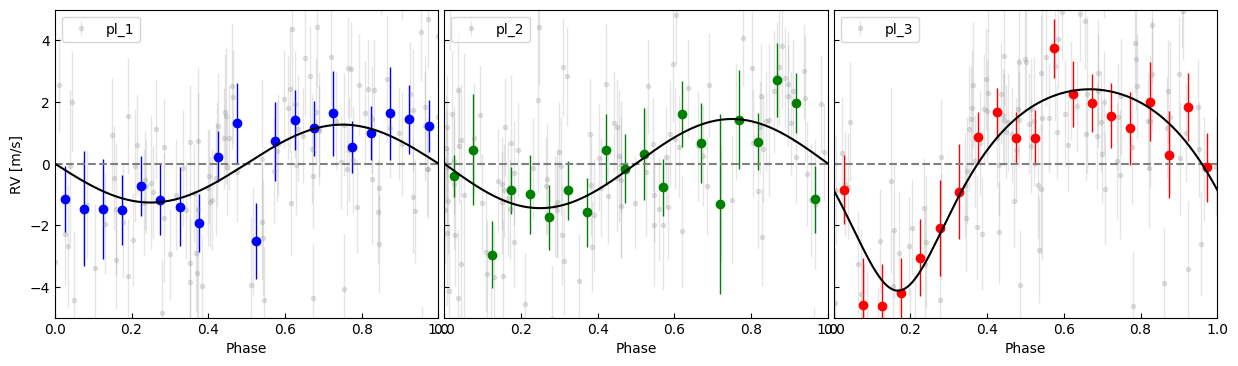

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,4))

pl = ["pl_1", "pl_2", "pl_3", "pl_1", "pl_2"]
cl = ["b","g","r"]
for i,n in enumerate(["pl_1", "pl_2", "pl_3"]):
    phase    = phase_fold(  t   = np.array(rv_out["time"]), 
                            per = result.params.P[i], 
                            t0  = result.params.T0[i], 
                            phase0 = 0)
    phase_sm = phase_fold(  t   = t_sm, 
                            per = result.params.P[i], 
                            t0  = result.params.T0[i], 
                            phase0 = 0)

    srt = np.argsort(phase_sm)

    pl.remove(n)

    subtract_signal    = rv_comp[pl[0]]    + rv_comp[pl[1]]
    subtract_signal_sm = rv_comp_sm[pl[0]] + rv_comp_sm[pl[1]]
    planet_signal      = rv_out["det_RV"]   - subtract_signal 

    p_bin, rv_bin, err_bin = bin_data(phase, planet_signal, rv_out["error"],bins=20)

    ax[i].errorbar(   phase, planet_signal,  rv_out["error"], 
                    fmt=".",c="gray", elinewidth=1, alpha=0.2,label=n)

    ax[i].errorbar(p_bin, rv_bin, err_bin, fmt="o", c=cl[i], elinewidth=1)

    ax[i].plot(phase_sm[srt], rv_comp_sm[n][srt],"k",zorder=4)

    # ax[i].fill_between(   phase_sm[srt],
    #                     (rvmod_sm.sigma_low - subtract_signal_sm)[srt], 
    #                     (rvmod_sm.sigma_high-subtract_signal_sm)[srt], 
    #                     color="cyan"
    #                 )

    ax[i].legend()
    ax[i].axhline(0,ls="--",c="gray")
    ax[i].set_xlabel("Phase")
    ax[0].set_ylabel("RV [m/s]")
    ax[i].set_ylim([-5,5])
    ax[i].set_xlim([0,1])
    ax[i].tick_params(direction="in")

plt.subplots_adjust(wspace=0.015)

### LC

In [14]:
result.lc.names

['K2-233_C15_detrended_cut.dat']

In [15]:
#load output data files for the lc fits
lc_out = result.lc.outdata['K2-233_C15_detrended_cut.dat']
lc_out.head()

,time,flux,error,full_mod,base_para,base_sine,base_spl,base_gp,base_total,transit,det_flux,residual,phase_1,phase_2,phase_3
0,7991.365514,1.000031,0.000093,0.999985,0.999985,0.0,1.0,0.0,0.999985,1.0,1.000046,0.000046,-0.131720,0.293236,0.416591
1,7991.385946,0.999915,0.000093,0.999985,0.999985,0.0,1.0,0.0,0.999985,1.0,0.999930,-0.000070,-0.123440,0.296131,0.417430
2,7991.406378,0.999975,0.000093,0.999985,0.999985,0.0,1.0,0.0,0.999985,1.0,0.999990,-0.000010,-0.115160,0.299025,0.418268
3,7991.426811,1.000011,0.000093,0.999985,0.999985,0.0,1.0,0.0,0.999985,1.0,1.000026,0.000026,-0.106879,0.301919,0.419107
4,7991.447243,1.000016,0.000093,0.999985,0.999985,0.0,1.0,0.0,0.999985,1.0,1.000031,0.000031,-0.098599,0.304813,0.419945


In [16]:
# evaluate the LC model
lcmod = result.lc.evaluate( time        = np.array(lc_out["time"]), 
                            return_std  = True, 
                            nsamp       = 500)

In [61]:
t_sm     = np.linspace( lc_out["time"].min(), 
                        lc_out["time"].max(), 
                        10000)

lcmod_sm = result.lc.evaluate(
                                time       = t_sm,  
                                return_std = True,
                                nsamp      = 500)

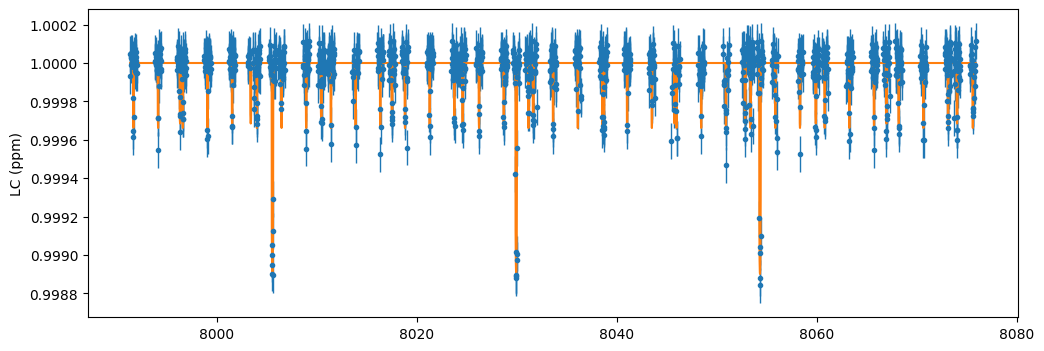

In [ ]:
plt.figure(figsize=(12,4))
plt.errorbar(lc_out["time"],lc_out["det_flux"], lc_out["error"],fmt=".", elinewidth=1)
plt.plot(t_sm, lcmod_sm.planet_model)
plt.ylabel("Flux");

In [63]:
lc_comp    = lcmod.components
lc_comp_sm = lcmod_sm.components

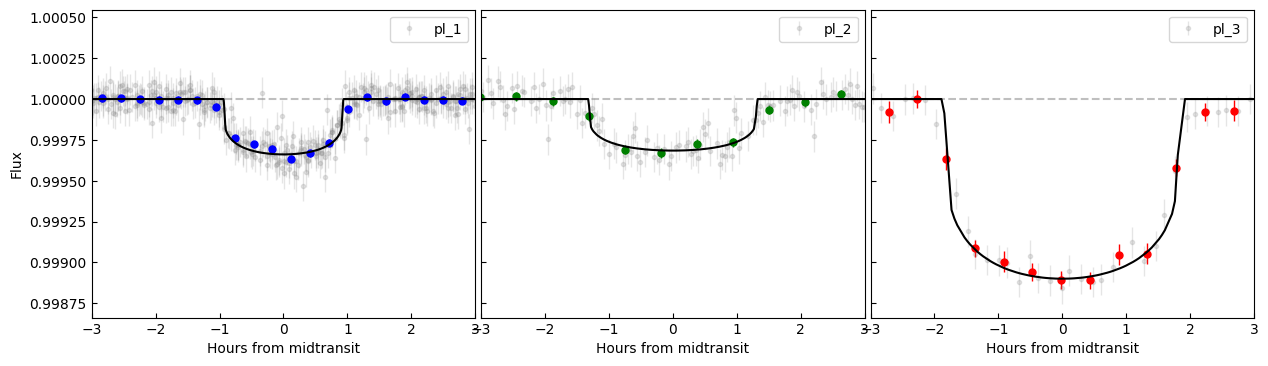

In [70]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,4))

pl = ["pl_1", "pl_2", "pl_3", "pl_1", "pl_2"]
cl = ["b","g","r"]
n_bin = [200, 300, 1300]
for i,n in enumerate(["pl_1", "pl_2", "pl_3"]):
    phase    = phase_fold(  t   = np.array(lc_out["time"]), 
                            per = result.params.P[i], 
                            t0  = result.params.T0[i], 
                            phase0 = -0.5)
    phase_sm = phase_fold(  t   = t_sm, 
                            per = result.params.P[i], 
                            t0  = result.params.T0[i], 
                            phase0 = -0.5)

    srt = np.argsort(phase_sm)

    pl.remove(n)

    subtract_signal    = lc_comp[pl[0]]    + lc_comp[pl[1]] -2
    subtract_signal_sm = lc_comp_sm[pl[0]] + lc_comp_sm[pl[1]] -2
    planet_signal      = lc_out["det_flux"]   - subtract_signal 

    p_bin, lc_bin, err_bin = bin_data(phase, planet_signal, lc_out["error"],bins=n_bin[i])

    ax[i].errorbar(   phase*result.params.P[i]*24, planet_signal,  lc_out["error"], 
                    fmt=".",c="gray", elinewidth=1, alpha=0.2,label=n)

    ax[i].errorbar(p_bin*result.params.P[i]*24, lc_bin, err_bin, fmt="o",ms=5, c=cl[i], elinewidth=1)

    ax[i].plot(phase_sm[srt]*result.params.P[i]*24, lc_comp_sm[n][srt],"k",zorder=4)

    # ax[i].fill_between(   phase_sm[srt]*result.params.P[i]*24,
    #                     (lcmod_sm.sigma_low - subtract_signal_sm)[srt], 
    #                     (lcmod_sm.sigma_high-subtract_signal_sm)[srt], 
    #                     color="cyan"
    #                 )

    ax[i].legend()
    ax[i].axhline(1,ls="--",c="gray", alpha=0.5)
    ax[i].set_xlabel("Hours from midtransit")
    ax[0].set_ylabel("Flux")
    ax[i].set_xlim([-3,3])
    ax[i].tick_params(direction="in")

# ax[-1].set_xlim([-0.01,0.01])

plt.subplots_adjust(wspace=0.015)